In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import sys
import os


In [2]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [3]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.25.0'

In [4]:

# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),'..', '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'src'))

sys.path.append(src_dir)


In [5]:


from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from constants import hbar, c , eV, MeV, GeV, G_F, kB


In [6]:

def initialize_parameters():
    N_sites = 4 # Number of qubits
    delta_m_squared = 0 # change accordingly with the desired Rog fit reproduction below 
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.full(N_sites // 2, delta_m_squared)
    omega = np.concatenate((omega_a, omega_b))
    print(omega)
    shots = 1000
    # Define the service.  This allows you to access IBM Quantum systems.
    service = QiskitRuntimeService()
    # Get a backend
    backend = service.least_busy(operational=True, simulator=False)
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 10  # Total time
    times = np.arange(0, ttotal, τ)  # Define time steps
    Δx = 1E-3 # length of the box of interacting neutrinos at a site in cm #variable
    L = 1 # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = 0 # mixing_angle #rad 
    # Initialize an array of zeros for all N_sites particles
    # mu = np.ones(N_sites)
    mu = 1
    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = mu * np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F *N_sites))

    # Create a B vector which would be same for all N particles
    B = np.array([np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)

    # Generate an Nx3 array for p with all zeros
    p = np.zeros((N_sites, 3))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file


    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times



In [7]:

def simulate(times, omega, N_sites, H, backend, shots, τ, tolerance):
    # Simulation and expected value calculation
    sigma_z_values = []
    survival_probabilities = []

    for t in times:
        qc = evolve_and_measure_circuit(t, H, N_sites)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)
        result = backend.run(isa_circuit, shots=shots).result()
        counts = result.get_counts(isa_circuit)
        
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots
        
        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        print(f"t: {t}, survival_probability: {survival_probability}")
        
        # Append values to the respective lists
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)

    # # Create a spline of the survival probabilities
    # spline = UnivariateSpline(times, survival_probabilities, s=0.03)
    # survival_probabilities = spline(times) # smoothed survival_probabilities array
    
    def find_first_local_minima_index(arr):
        n = len(arr)
        for i in range(1, n - 1):
            if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
                return i
        return -1

    # Index of the first minimum of the survival probabilities
    i_first_local_min = find_first_local_minima_index(survival_probabilities)

    # Writing if_else statement to communicate if local minima (not) found
    if i_first_local_min != -1:
        print(f"Index of the first local minimum: {i_first_local_min}")
    else:
        print("No local minimum found in the array.")
        
        
    # Time at which the first minimum survival probability is reached
    t_min = τ * i_first_local_min
    print(f"Corresponding time of first minimum index= {t_min}")

    # Fixed Constants for Rogerro's fit (only self-interaction term)
    a_t = 0
    b_t = 2.105
    c_t = 0
    
    t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
    print("t_p_Rog= ", t_p_Rog)

    # Assert condition
    # assert abs(t_min - t_p_Rog) < τ + tolerance, "The time of the first minimum survival probability is not within the expected range."

    return sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min



In [8]:
def plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min):
    # Plot the survival probability at site 1 against time
    plt.plot(times, survival_probabilities, label='Survival Probability')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability at site 1')
    plt.title(f'Survival Probability at site 1 vs Time ({N_sites} Qubits, \n $H_{{SI}}$ Term), All-to-All Interaction)')

    # Add scatter point for Rogerro's fit
    plt.scatter([t_p_Rog], [survival_probabilities[np.abs(times - t_p_Rog).argmin()]], color='red', label="t_p_Rog", zorder=5)

    # Add scatter point for the first local minimum
    if i_first_local_min != -1:
        plt.scatter([t_min], [survival_probabilities[np.abs(times - t_min).argmin()]], color='blue', label="First Local Min", zorder=5)

    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [9]:
    
def main():
    N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times= initialize_parameters()
    H = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
    sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min = simulate(times, omega, N_sites, H, backend, shots, τ, tolerance)
    plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min)


[0 0 0 0]


/home/zohalaraib/Quantinuum/src/momentum.py:15: RuntimeWarning: invalid value encountered in divide
  p_i_hat = p[i, :] / p_i_mod
/tmp/ipykernel_1826743/1402365213.py:10: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  result = backend.run(isa_circuit, shots=shots).result()


t: 0.0, survival_probability: 0.992
t: 0.05, survival_probability: 0.497
t: 0.1, survival_probability: 0.492
t: 0.15000000000000002, survival_probability: 0.525
t: 0.2, survival_probability: 0.504
t: 0.25, survival_probability: 0.484
t: 0.30000000000000004, survival_probability: 0.488
t: 0.35000000000000003, survival_probability: 0.501
t: 0.4, survival_probability: 0.508
t: 0.45, survival_probability: 0.514
t: 0.5, survival_probability: 0.502
t: 0.55, survival_probability: 0.49
t: 0.6000000000000001, survival_probability: 0.526
t: 0.65, survival_probability: 0.496
t: 0.7000000000000001, survival_probability: 0.524
t: 0.75, survival_probability: 0.498
t: 0.8, survival_probability: 0.502
t: 0.8500000000000001, survival_probability: 0.525
t: 0.9, survival_probability: 0.529
t: 0.9500000000000001, survival_probability: 0.483
t: 1.0, survival_probability: 0.512
t: 1.05, survival_probability: 0.507
t: 1.1, survival_probability: 0.517
t: 1.1500000000000001, survival_probability: 0.481
t: 1.20

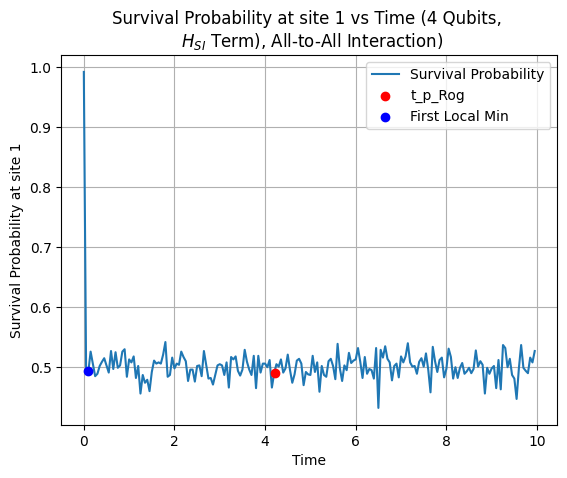

In [10]:
if __name__ == "__main__":
    main()